In [1]:
%matplotlib inline
import pandas as pd
import os

Data from http://fowler.ucsd.edu/judicial.htm, following the paper:

Network Analysis and the Law: 
Measuring the Legal Importance of Supreme Court Precedents.
James H. Fowler, Timothy R. Johnson, James F. Spriggs II, Sangick Jeon, Paul J. Wahlbeck 
Political Analysis, 15 (3): 324-346 (July 2007)

In [2]:
fpath = '/media/sf_VBox_Shared/networks/supreme-court/'
#df = pd.read_csv(os.path.join(fpath, 'SCDB_Legacy_04_caseCentered_Citation_utf8.csv'))
df_links = pd.read_csv(os.path.join(fpath, 'Pol_Analysis_ussc_cites.csv'))

In [3]:
df_nodes = pd.read_stata(os.path.join(fpath, 'Pol_Analysis_replication.dta'))

In [4]:
df_links.head()

,cited_case,citing_case
0,1796 U.S. LEXIS 409,1792 U.S. LEXIS 587
1,1793 U.S. LEXIS 249,1793 U.S. LEXIS 247
2,1796 U.S. LEXIS 409,1793 U.S. LEXIS 247
3,1796 U.S. LEXIS 409,1793 U.S. LEXIS 248
4,1792 U.S. LEXIS 590,1793 U.S. LEXIS 249


In [5]:
df_nodes.head()

,name,usid,lexid,amiciz_num,auth_num,hub_num,oxford_num,cq_num,nyt_num,insc_num,...,age_sq,insc_num_lag,apin_num_lag,stin_num_lag,poutevcent_num_lag,pinevcent_num_lag,phub_num_lag,pauth_num_lag,outsc_num_lag,sc_cumul_cites_lag
0,West v. Barnes,2 u.S. 401,1791 U.S. LEXIS 189,NaN,0.0,0.0,0.0,0.0,NaN,0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,West v. Barnes,2 U.S. 401,1791 U.S. LEXIS 189,NaN,0.0,0.0,0.0,0.0,NaN,0,...,1.0,0.0,0.0,0.0,0.583333,0.583333,0.583333,0.583333,0.0,0.0
2,West v. Barnes,2 U.S. 401,1791 U.S. LEXIS 189,NaN,0.0,0.0,0.0,0.0,NaN,0,...,4.0,0.0,0.0,0.0,0.583333,0.583333,0.583333,0.583333,0.0,0.0
3,West v. Barnes,2 U.S. 401,1791 U.S. LEXIS 189,NaN,0.0,0.0,0.0,0.0,NaN,0,...,9.0,0.0,0.0,0.0,0.444444,0.555556,0.500000,0.444444,0.0,0.0
4,West v. Barnes,2 U.S. 401,1791 U.S. LEXIS 189,NaN,0.0,0.0,0.0,0.0,NaN,0,...,16.0,0.0,0.0,0.0,0.454545,0.545455,0.500000,0.454545,0.0,0.0


In [6]:
df_nodes.shape, df_links.shape

((2434607, 26), (202167, 2))

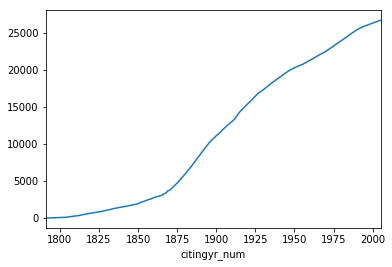

In [7]:
df_nodes.groupby('citingyr_num').count()['lexid'].plot()

## citation distance
To replicate the results from Bommarito et al., we take the first 25 years of data

In [8]:
import networkx as nx
from nwtools import communities
import numpy as np
from matplotlib import pyplot as plt

In [9]:
min_year = df_nodes['citingyr_num'].min()
df_nodes_sub = df_nodes[df_nodes['citingyr_num']==min_year+25]

In [10]:
df_nodes_sub.shape

(507, 26)

In [11]:
df_links_sub = df_links[df_links['citing_case'].isin(df_nodes_sub.lexid)&df_links['cited_case'].isin(df_nodes_sub.lexid)]
df_links_sub = df_links_sub.drop_duplicates()

In [12]:
df_links_sub.shape

(162, 2)

In [13]:
graph = nx.from_pandas_edgelist(df_links_sub, source='citing_case', target='cited_case', create_using=nx.DiGraph())
graph.number_of_nodes(), graph.number_of_edges()

(182, 162)

In [14]:
graph = graph.subgraph(sorted(nx.weakly_connected_components(graph), key=len)[-1]).copy()
graph.number_of_nodes(), graph.number_of_edges()

(62, 76)

In [15]:
nx.algorithms.dag.is_directed_acyclic_graph(graph)

False

In [16]:
# Clean up: remove cycles
self_loops = [(a,b) for a, b in graph.edges if a==b]
graph.remove_edges_from(self_loops)

cycles = nx.algorithms.cycles.simple_cycles(graph)
for c in cycles:
    if len(c)==2:
        a, b = c
        if a<b:
            graph.remove_edge(b,a)
        else:
            graph.remove_edge(a,b)
            
nx.algorithms.dag.is_directed_acyclic_graph(graph)

True

In [17]:
graph.number_of_nodes(), graph.number_of_edges()

(62, 73)

In [18]:
dist, labels = communities.citation_distance_matrix(graph)

In [19]:
print(np.all(dist==dist.T))
print(sum(dist.diagonal()))

True
0.0


In [21]:
len(labels), dist.shape

(62, (62, 62))

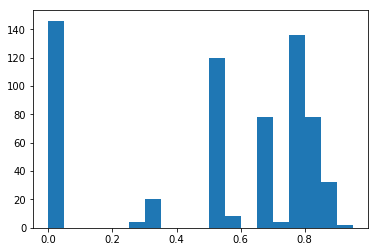

In [22]:
plt.hist(dist.flat, bins=np.arange(0, 1, .05));

In [23]:
import scipy.cluster
cl = scipy.cluster.hierarchy.linkage(scipy.spatial.distance.squareform(dist), method='single')

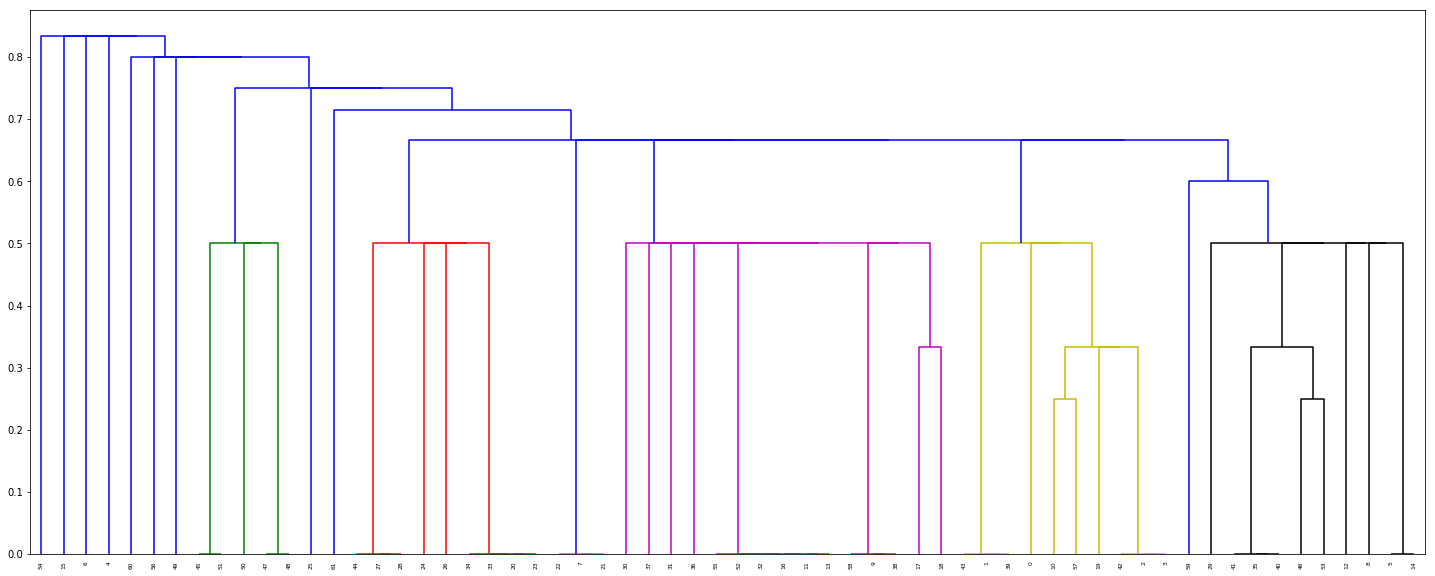

In [24]:
fig = plt.figure(figsize=(25, 10))
scipy.cluster.hierarchy.dendrogram(cl);

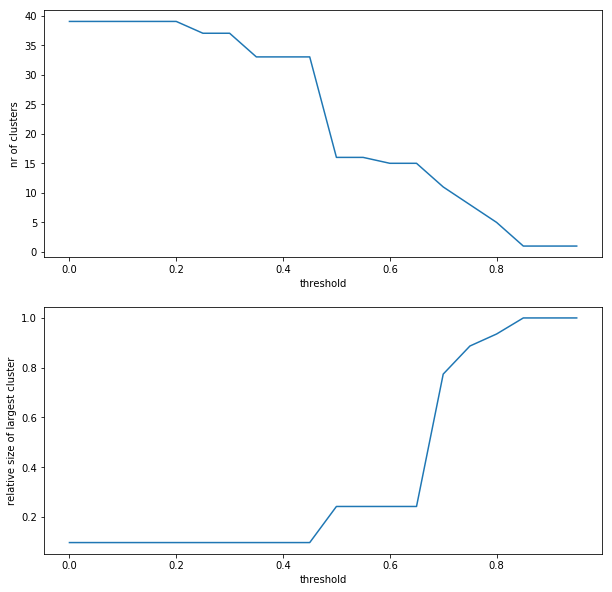

In [25]:
# How many clusters do we have for different distance cut-off values
fig, axes = plt.subplots(2, figsize=(10,10))
t_range = np.arange(0, 1, 0.05)
cluster_sizes = np.zeros(len(t_range))
largest_size = np.zeros(len(t_range))
for i in range(len(t_range)):
    clusters = scipy.cluster.hierarchy.fcluster(cl, t_range[i], criterion='distance')
    clusters_unique = set(clusters)
    cluster_sizes[i] = len(clusters_unique)
    largest_size[i] = max([list(clusters).count(c) for c in clusters_unique]) / len(clusters)
axes[0].plot(t_range, cluster_sizes)
axes[1].plot(t_range, largest_size)

axes[0].set_xlabel('threshold')
axes[0].set_ylabel('nr of clusters')
axes[1].set_xlabel('threshold')
axes[1].set_ylabel('relative size of largest cluster')
plt.show()

In [31]:
clusters = scipy.cluster.hierarchy.fcluster(cl, 0.6, criterion='distance')
clusters_dict = {labels[i]: clusters[i] for i in range(len(clusters))} 
clusters_list = [clusters_dict[k] for k in graph.nodes()]

In [46]:

pos_rescaled = nx.rescale_layout(np.array([pos_dict[k] for k in graph.nodes()]), scale=5)

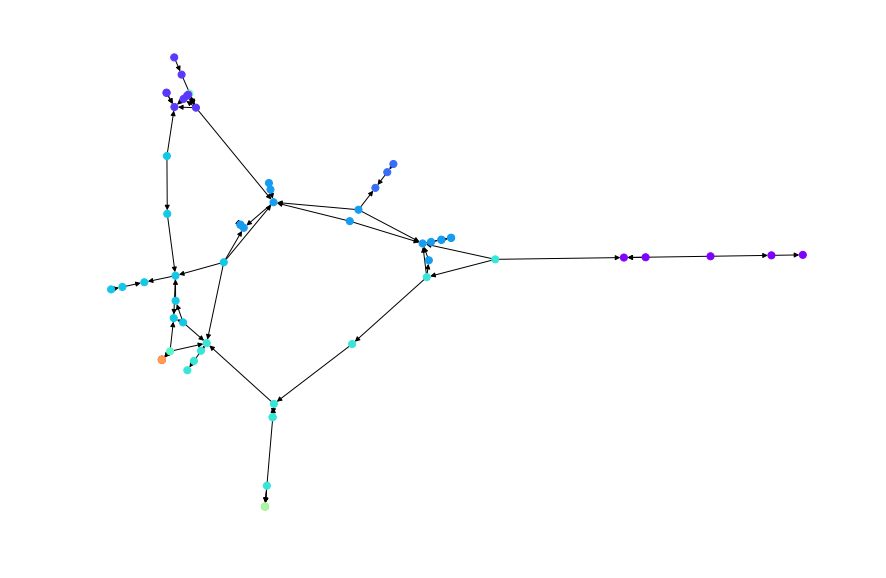

In [65]:
fig = plt.figure(figsize=(15, 10))
ax = plt.gca()
pos_dict = nx.layout.spectral_layout(graph)
nx.draw(graph, node_color=clusters_list, pos=pos_dict, cmap='rainbow', node_size=50, ax=ax)

In [61]:
nx.draw_networkx?

Signature: nx.draw_networkx(G, pos=None, arrows=True, with_labels=True, **kwds)
Docstring:
Draw the graph G using Matplotlib.

Draw the graph with Matplotlib with options for node positions,
labeling, titles, and many other drawing features.
See draw() for simple drawing without labels or axes.

Parameters
----------
G : graph
   A networkx graph

pos : dictionary, optional
   A dictionary with nodes as keys and positions as values.
   If not specified a spring layout positioning will be computed.
   See :py:mod:`networkx.drawing.layout` for functions that
   compute node positions.

arrows : bool, optional (default=True)
   For directed graphs, if True draw arrowheads.
   Note: Arrows will be the same color as edges.

arrowstyle : str, optional (default='-|>')
    For directed graphs, choose the style of the arrowsheads.
    See :py:class: `matplotlib.patches.ArrowStyle` for more
    options.

arrowsize : int, optional (default=10)
   For directed graphs, choose the size of the arrow 